In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
os.chdir('/content/drive/MyDrive/CS105BProject/bias' )
sys.path.append('/content/drive/MyDrive/CS105BProject')
sys.path.append('/content/drive/MyDrive/CS105BProject/bias/')
sys.path.append(os.getcwd())

In [3]:
import pickle
import numpy as np
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


steps = ['none', 'neg', 'stop', 'pos', 'stem', 'all', 'pos-neg', 'pos-stop','formal', 'informal', 'pos-neg-stop', 'EMOINT', 'EMO_LEXI']
steps_dic = {'none':'none', 'neg':'neg', 'stop':'stop', 'pos':'pos', 'stem':'stem', 'all':'all', 
             'pos-neg':'pos+neg', 'pos-stop':'pos+stop', 'formal':'formal', 'informal':'informal',
             'pos-neg-stop': 'pos+neg+stop', 'EMOINT': 'Emotion intensity', 'EMO_LEXI': 'Emotion Lexicon'}
inputtypes = ["CLAIM_ONLY", "EVIDENCE_ONLY", "CLAIM_AND_EVIDENCE"]
inputtypes_dic = {"CLAIM_ONLY": "Claim", "EVIDENCE_ONLY": "Evidence", "CLAIM_AND_EVIDENCE": "Claim+Evidence"}
# datasets = ["snes", "pomt"]
# datasets_dic = {"snes": "Snopes", "pomt": "PolitiFact" }
datasets = ["snes"]
datasets_dic = {"snes": "Snopes"}
# datasets = ["pomt"]
# datasets_dic = {"pomt": "PolitiFact"}
methods = ["bert"]
methods_dic = {"bert": "BERT"}

def process_content(content):
    val_store = content[0]
    test_store = content[1]
    other_test_store = content[2]
    misc = content[3]

    test_remove_top_bottom = content[1][-2]
    test_remove_bottom_top = content[1][-1]
    other_test_remove_top_bottom = content[2][-2]
    other_test_remove_bottom_top = content[2][-1]

    val_f1_micro = val_store[0]
    val_f1_macro = val_store[1]

    test_f1_micro = test_store[0]
    test_f1_macro = test_store[1]

    other_test_f1_micro = other_test_store[0]
    other_test_f1_macro = other_test_store[1]

    test_remove_top_bottom_f1_micro = [v[0] for v in test_remove_top_bottom]
    test_remove_top_bottom_f1_macro = [v[1] for v in test_remove_top_bottom]

    test_remove_bottom_top_f1_micro = [v[0] for v in test_remove_bottom_top]
    test_remove_bottom_top_f1_macro = [v[1] for v in test_remove_bottom_top]

    other_test_remove_top_bottom_f1_micro = [v[0] for v in other_test_remove_top_bottom]
    other_test_remove_top_bottom_macro = [v[1] for v in other_test_remove_top_bottom]

    other_test_remove_bottom_top_f1_micro = [v[0] for v in other_test_remove_bottom_top]
    other_test_remove_bottom_top_f1_macro = [v[1] for v in other_test_remove_bottom_top]

    return val_f1_micro, val_f1_macro, test_f1_micro, test_f1_macro, other_test_f1_micro, other_test_f1_macro, \
           test_remove_top_bottom_f1_micro, test_remove_top_bottom_f1_macro, \
           test_remove_bottom_top_f1_micro, test_remove_bottom_top_f1_macro, \
           other_test_remove_top_bottom_f1_micro, other_test_remove_top_bottom_macro, \
           other_test_remove_bottom_top_f1_micro, other_test_remove_bottom_top_f1_macro

def get_results(dataset, inputtype, model, step, other=None):
    path = "./results/"
    # print(f'step: {step}')

    filenames = glob.glob(path + "-".join([str(v) for v in [model, dataset, inputtype, step]]) + "*.pkl")
    # print(filenames)
    
    if other is not None:
        filenames = glob.glob(path + "-".join([str(v) for v in [other, model, dataset, inputtype, step]]) + "*.pkl")

    best_val_f1_macro = -np.inf
    best_filename = None
    best_misc = None
    for filename in filenames:
        content = pickle.load(open(filename, "rb"))
        val_f1_macro = (content[0][1]+content[0][0])/2

        if val_f1_macro > best_val_f1_macro:
            best_filename = filename
            best_val_f1_macro = val_f1_macro
            best_misc = content[-1]

    content = pickle.load(open(best_filename, "rb"))
#     print(dataset, inputtype, model,)
#     print(best_misc)
#     print("--")
    return process_content(content)

def get_test_f1_micro(vals):
    return vals[2]

def get_test_f1_macro(vals):
    return vals[3]

def get_other_test_f1_micro(vals):
    return vals[4]

def get_other_test_f1_macro(vals):
    return vals[5]

def get_test_remove_top_bottom_f1_micro(vals):
    return vals[6]

def get_test_remove_top_bottom_f1_macro(vals):
    return vals[7]

def get_test_remove_bottom_top_f1_micro(vals):
    return vals[8]

def get_test_remove_bottom_top_f1_macro(vals):
    return vals[9]

def my_round(val):
    return "{:.3f}".format(val)

#inputtypes = ["CLAIM_ONLY", "EVIDENCE_ONLY", "CLAIM_AND_EVIDENCE"]
def plot_snippets(method, step, dataset, resdic):
    evid = resdic[step][method][dataset]["EVIDENCE_ONLY"]
    claim_evid = resdic[step][method][dataset]["CLAIM_AND_EVIDENCE"]

    evid_original = [get_test_f1_macro(evid)]
    claim_evid_original = [get_test_f1_macro(claim_evid)]

    evid_top = evid_original + get_test_remove_top_bottom_f1_macro(evid)
    evid_bottom = evid_original + get_test_remove_bottom_top_f1_macro(evid)

    claim_evid_top = claim_evid_original + get_test_remove_top_bottom_f1_macro(claim_evid)
    claim_evid_bottom = claim_evid_original + get_test_remove_bottom_top_f1_macro(claim_evid)

    plt.figure(figsize=(5, 3.5))
    xs = np.arange(11)
    plt.plot(xs, evid_top, "--*b", label="Evid: remove from top")
    plt.plot(xs, evid_bottom, "-*b", label="Evid: remove from bottom")

    plt.plot(xs, claim_evid_top, "--+r", label="Claim+Evid: remove from top")
    plt.plot(xs, claim_evid_bottom, "-+r", label="Claim+Evid: remove from bottom")

    plt.title(datasets_dic[dataset] + ": " + methods_dic[method] + ", " + steps_dic[step])
    plt.legend()
    plt.xlabel("#snippets removed")
    plt.ylabel("F1 macro")
    plt.xticks(xs)
    plt.tight_layout()
    plt.savefig("figs/" + datasets_dic[dataset] + "_" + methods_dic[method] + "_" + steps_dic[step] + ".pdf")

def print_table(method, step, dataset, resdic): # [method][dataset][t]    
    
    print(f'\nmethod: {method} \t preprocess: {step} \t dataset: {dataset}')
    for inputtype in inputtypes:
        line = inputtypes_dic[inputtype]
       
        for fun in [get_test_f1_micro, get_test_f1_macro, get_other_test_f1_micro, get_other_test_f1_macro]:
            line = line + " & " + my_round(fun(resdic[step][method][dataset][inputtype]))
        line += " \\\\"
        print(line)
  

In [4]:
class vars():
    def __init__(self, mode, inputtype):
        if mode == "bow":
            self.dataset = "snes"
            self.inputtype = inputtype
            self.filter_websites = 0
            self.model = "bow"
            self.batchsize = 2
            self.eval_per_epoch = 1
            self.lr = 0.0001
        elif mode == 'lstm':
            self.dataset = "snes"
            self.inputtype = inputtype
            self.filter_websites = 0
            self.model = "lstm"
            self.batchsize = 16
            self.eval_per_epoch = 1
            self.lr = 0.0001
            self.lstm_hidden_dim = 128
            self.lstm_layers = 2
            self.lstm_dropout = 0.1
        elif mode == 'bert':
            self.dataset = "snes"
            self.inputtype = inputtype
            self.filter_websites = 0
            self.model = "bert"
            self.batchsize = 6
            self.eval_per_epoch = 1
            self.lr = 0.000003            
            

mode = 'bert'
inputtype = 'CLAIM_ONLY'
args = vars(mode, inputtype)

In [5]:
!pwd

/content/drive/MyDrive/CS105BProject/bias


In [6]:
!ls

analyze_pomt.ipynb  model_selection.py	requirements.txt
analyze_snes.ipynb  parameters.py	results
figs		    prepare_data.py	sorted.uk.word.unigrams
mainbak.ipynb	    preprocessed	utils
model		    __pycache__



method: bert 	 preprocess: none 	 dataset: snes
Claim & 0.511 & 0.296 & 0.239 & 0.200 \\
Evidence & 0.556 & 0.298 & 0.264 & 0.211 \\
Claim+Evidence & 0.607 & 0.295 & 0.262 & 0.192 \\
************


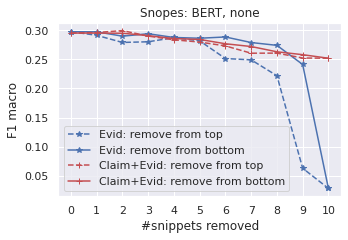


method: bert 	 preprocess: neg 	 dataset: snes
Claim & 0.545 & 0.332 & 0.241 & 0.196 \\
Evidence & 0.552 & 0.322 & 0.261 & 0.235 \\
Claim+Evidence & 0.573 & 0.324 & 0.259 & 0.198 \\
************


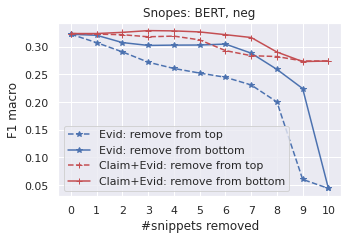


method: bert 	 preprocess: stop 	 dataset: snes
Claim & 0.528 & 0.273 & 0.273 & 0.207 \\
Evidence & 0.521 & 0.261 & 0.237 & 0.183 \\
Claim+Evidence & 0.519 & 0.304 & 0.237 & 0.180 \\
************


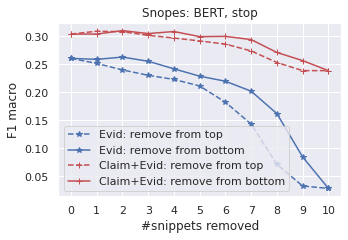


method: bert 	 preprocess: pos 	 dataset: snes
Claim & 0.552 & 0.267 & 0.268 & 0.207 \\
Evidence & 0.576 & 0.294 & 0.263 & 0.195 \\
Claim+Evidence & 0.590 & 0.340 & 0.240 & 0.199 \\
************


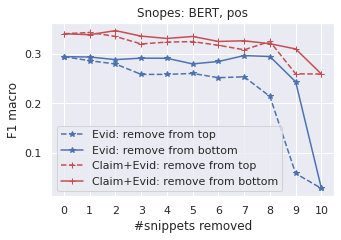


method: bert 	 preprocess: stem 	 dataset: snes
Claim & 0.568 & 0.276 & 0.258 & 0.207 \\
Evidence & 0.588 & 0.294 & 0.265 & 0.205 \\
Claim+Evidence & 0.451 & 0.286 & 0.216 & 0.197 \\
************


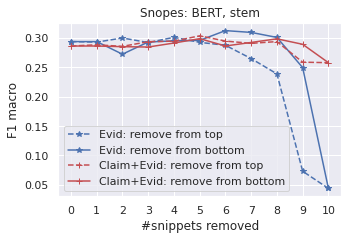


method: bert 	 preprocess: all 	 dataset: snes
Claim & 0.546 & 0.322 & 0.251 & 0.194 \\
Evidence & 0.578 & 0.283 & 0.265 & 0.201 \\
Claim+Evidence & 0.526 & 0.313 & 0.239 & 0.171 \\
************


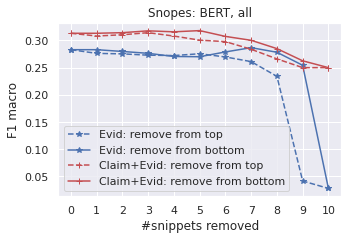


method: bert 	 preprocess: pos-neg 	 dataset: snes
Claim & 0.510 & 0.278 & 0.264 & 0.204 \\
Evidence & 0.526 & 0.299 & 0.254 & 0.220 \\
Claim+Evidence & 0.577 & 0.311 & 0.259 & 0.217 \\
************


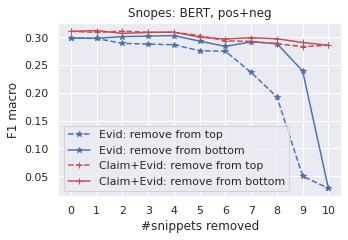


method: bert 	 preprocess: pos-stop 	 dataset: snes
Claim & 0.552 & 0.267 & 0.268 & 0.207 \\
Evidence & 0.551 & 0.300 & 0.267 & 0.217 \\
Claim+Evidence & 0.527 & 0.312 & 0.233 & 0.209 \\
************


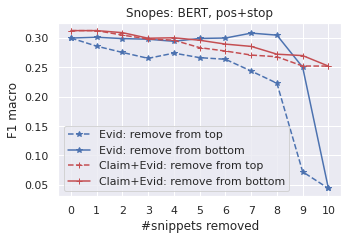


method: bert 	 preprocess: formal 	 dataset: snes
Claim & 0.458 & 0.297 & 0.223 & 0.174 \\
Evidence & 0.520 & 0.312 & 0.243 & 0.204 \\
Claim+Evidence & 0.482 & 0.285 & 0.220 & 0.178 \\
************


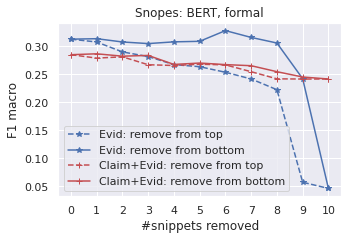


method: bert 	 preprocess: informal 	 dataset: snes
Claim & 0.536 & 0.298 & 0.257 & 0.207 \\
Evidence & 0.537 & 0.304 & 0.252 & 0.229 \\
Claim+Evidence & 0.611 & 0.332 & 0.269 & 0.215 \\
************


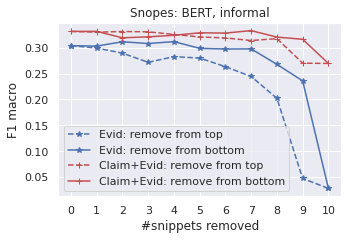


method: bert 	 preprocess: pos-neg-stop 	 dataset: snes
Claim & 0.510 & 0.278 & 0.264 & 0.204 \\
Evidence & 0.507 & 0.308 & 0.244 & 0.219 \\
Claim+Evidence & 0.577 & 0.311 & 0.259 & 0.217 \\
************


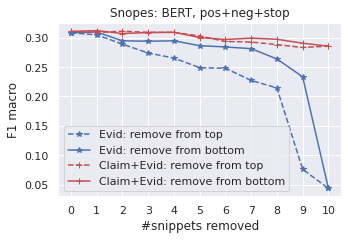


method: bert 	 preprocess: EMOINT 	 dataset: snes
Claim & 0.542 & 0.298 & 0.241 & 0.181 \\
Evidence & 0.586 & 0.306 & 0.269 & 0.200 \\
Claim+Evidence & 0.582 & 0.344 & 0.258 & 0.212 \\
************


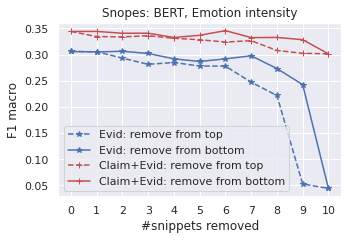


method: bert 	 preprocess: EMO_LEXI 	 dataset: snes
Claim & 0.517 & 0.319 & 0.234 & 0.192 \\
Evidence & 0.516 & 0.327 & 0.241 & 0.229 \\
Claim+Evidence & 0.519 & 0.324 & 0.229 & 0.183 \\
************


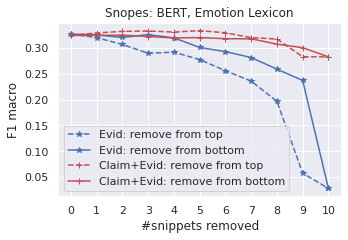

In [7]:

resdic = {}
for step in steps:
    resdic[step] = {}
    for method in methods:
        resdic[step][method] = {}
        for dataset in datasets:
            resdic[step][method][dataset] = {}
            for t in inputtypes:
                resdic[step][method][dataset][t] = get_results(dataset, t, method, step)

for step in steps:
    print_table("bert", step, "snes", resdic)
    plot_snippets("bert", step, "snes", resdic)
    print('************')
    plt.show()
    
# for step in steps:
#     print_table("bert", step, "pomt", resdic)
#     plot_snippets("bert", step, "pomt", resdic)
#     print('************')

#     plt.show()

